In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from tensorflow.keras.utils import to_categorical
from scipy.fft import rfft
from statsmodels.tsa.stattools import acf
import tensorflow as tf

In [2]:
# --- 1. Simulation Function ---
def simulate_black_hole_lightcurve(fs, fc, fm, qpo_amplitude, duration,
                                   noise_mean=0, noise_std=0.5,
                                   include_qpo=True, modulation_index=0.5):
    """
    Simulate a black hole light curve with stochastic noise and an amplitude-modulated QPO signal.

    Parameters:
        fs : int
            Sampling frequency (Hz)
        fc : float
            Carrier frequency (Hz) for QPO
        fm : float
            Modulating frequency (Hz) for QPO
        qpo_amplitude : float
            Amplitude of the carrier signal (QPO)
        duration : float
            Duration of lightcurve (seconds)
        noise_mean : float
            Mean of the Gaussian noise
        noise_std : float
            Standard deviation of the Gaussian noise
        include_qpo : bool
            Whether to include the QPO signal
        modulation_index : float
            Modulation index for AM signal

    Returns:
        t : np.ndarray
            Time array
        flux : np.ndarray
            Normalized flux array
    """
    # Time array
    t = np.arange(0, duration, 1/fs)

    # White noise
    white_noise = np.random.normal(noise_mean, noise_std, size=len(t))
    white_noise = np.exp(white_noise)

    if include_qpo and qpo_amplitude > 0:
        # Modulating signal
        msg = qpo_amplitude * np.cos(2 * np.pi * fm * t)

        # Carrier signal
        carrier = qpo_amplitude * np.cos(2 * np.pi * fc * t)

        # AM QPO signal
        qpo = carrier * (1 + modulation_index * msg / qpo_amplitude)
    else:
        qpo = 0

    # Combine noise and QPO signal
    flux = white_noise + qpo

    # Normalize
    flux = (flux - np.mean(flux)) / np.std(flux)

    return t, flux

In [3]:
def generate_dataset_with_random_amplitudes(output_dir, num_samples=5000,
                                            fs=1, duration=512,
                                            modulation_index=0.5,
                                            amp_range=(0.1, 1.0)):
    """
    Generate dataset of light curves with random QPO amplitudes from a given range.

    Parameters:
        output_dir : str
            Path to save dataset
        num_samples : int
            Total number of samples (half QPO, half non-QPO)
        fs : int
            Sampling frequency
        duration : int
            Length of each light curve in seconds
        modulation_index : float
            Modulation index for AM QPO
        amp_range : tuple
            Range of amplitudes for QPO (min, max)
    """
    os.makedirs(output_dir, exist_ok=True)
    seq_length = int(duration * fs)
    dataset = []
    labels = []

    for _ in range(num_samples // 2):
        # Random QPO parameters
        fc = np.random.uniform(0.01, 1.0)
        fm = np.random.uniform(0.005, 0.1)
        amp = np.random.uniform(*amp_range)

        # QPO light curve
        t, flux_qpo = simulate_black_hole_lightcurve(
            fs, fc, fm, amp, duration, include_qpo=True,
            modulation_index=modulation_index)

        # Non-QPO light curve (same params but QPO off)
        _, flux_non_qpo = simulate_black_hole_lightcurve(
            fs, fc, fm, amp, duration, include_qpo=False,
            modulation_index=modulation_index)

        dataset.append(flux_qpo[:seq_length].reshape(-1, 1))
        labels.append(1)

        dataset.append(flux_non_qpo[:seq_length].reshape(-1, 1))
        labels.append(0)

    dataset = np.array(dataset)
    labels = to_categorical(np.array(labels), 2)

    np.savez_compressed(os.path.join(output_dir, 'data.npz'), X=dataset, y=labels)


In [ ]:
output_folder = "qpo_experiments/dataset_random_amp"
generate_dataset_with_random_amplitudes(
    output_folder, num_samples=5000, amp_range=(0.6, 1.0))


In [5]:
from sklearn.model_selection import train_test_split

def load_split_dataset(npz_path, batch_size=64, test_size=0.2, shuffle=True):
    data = np.load(npz_path)
    X = data['X']  # (N, 512, 1)

    # Split
    X_train, X_val = train_test_split(X, test_size=test_size, random_state=42)

    # TF Datasets
    train_ds = tf.data.Dataset.from_tensor_slices(X_train.astype(np.float32))
    val_ds = tf.data.Dataset.from_tensor_slices(X_val.astype(np.float32))

    if shuffle:
        train_ds = train_ds.shuffle(buffer_size=10000)
    train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds


In [6]:
def build_generator(latent_dim=100, seq_length=512):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(128),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(seq_length * 32),
        tf.keras.layers.Reshape((seq_length, 32)),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='tanh'))
    ])
    return model
def build_discriminator(seq_length=512):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(seq_length, 1)),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(64),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model
class TimeSeriesGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(TimeSeriesGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        self.gen_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.disc_optimizer = tf.keras.optimizers.Adam(1e-4)

    def compile(self):
        super().compile()

    @tf.function
    def train_step(self, real_data):
        batch_size = tf.shape(real_data)[0]
        noise = tf.random.normal([batch_size, self.latent_dim])

        # Generate fake data
        generated_data = self.generator(noise, training=True)

        # Labels
        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))

        # Train discriminator
        with tf.GradientTape() as disc_tape:
            real_output = self.discriminator(real_data, training=True)
            fake_output = self.discriminator(generated_data, training=True)
            disc_loss = self.loss_fn(real_labels, real_output) + self.loss_fn(fake_labels, fake_output)

        grads_disc = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(grads_disc, self.discriminator.trainable_variables))

        # Train generator
        noise = tf.random.normal([batch_size, self.latent_dim])
        with tf.GradientTape() as gen_tape:
            generated_data = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_data, training=True)
            gen_loss = self.loss_fn(real_labels, fake_output)

        grads_gen = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(grads_gen, self.generator.trainable_variables))

        return {"gen_loss": gen_loss, "disc_loss": disc_loss}


In [7]:
import matplotlib.pyplot as plt
from scipy.signal import welch
from statsmodels.tsa.stattools import acf
from scipy.stats import lognorm

def plot_psd(series, fs=1, label='PSD'):
    f, Pxx = welch(series, fs=fs, nperseg=256)
    plt.semilogy(f, Pxx, label=label)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title("Power Spectral Density")
    plt.legend()

def plot_acf(series, lags=100, label='ACF'):
    autocorr = acf(series, nlags=lags, fft=True)
    plt.plot(autocorr, label=label)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title("ACF")
    plt.legend()

def plot_flux_histogram(series, label='Generated'):
    shape, loc, scale = lognorm.fit(series - np.min(series) + 1e-6)
    x = np.linspace(np.min(series), np.max(series), 100)
    pdf = lognorm.pdf(x, shape, loc, scale)

    plt.hist(series, bins=40, density=True, alpha=0.6, label=f"{label} Flux")
    plt.plot(x, pdf, '--', label=f"LogNorm Fit ({label})")
    plt.xlabel("Flux")
    plt.ylabel("Density")
    plt.title("Flux Histogram with Log-normal Fit")
    plt.legend()


In [8]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, generator, val_dataset, latent_dim, num_samples=3):
        super().__init__()
        self.generator = generator
        self.val_dataset = val_dataset
        self.latent_dim = latent_dim
        self.num_samples = num_samples

    def on_epoch_end(self, epoch, logs=None):
        print(f"\n🧪 Epoch {epoch + 1}: Generating and evaluating samples...")
        noise = tf.random.normal([self.num_samples, self.latent_dim])
        generated = self.generator(noise, training=False).numpy().squeeze()

        # Get real samples from validation set
        real_samples = next(iter(self.val_dataset)).numpy().squeeze()[:self.num_samples]

        for i in range(self.num_samples):
            fig, axes = plt.subplots(1, 3, figsize=(18, 4))

            plt.sca(axes[0])
            plot_psd(generated[i], label='Generated')
            plot_psd(real_samples[i], label='Real')

            plt.sca(axes[1])
            plot_acf(generated[i], label='Generated')
            plot_acf(real_samples[i], label='Real')

            plt.sca(axes[2])
            plot_flux_histogram(generated[i], label='Generated')
            plot_flux_histogram(real_samples[i], label='Real')

            plt.suptitle(f"Sample {i + 1} – Epoch {epoch + 1}")
            plt.tight_layout()
            plt.show()


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - disc_loss: 1.3960 - gen_loss: 0.6676
🧪 Epoch 1: Generating and evaluating samples...


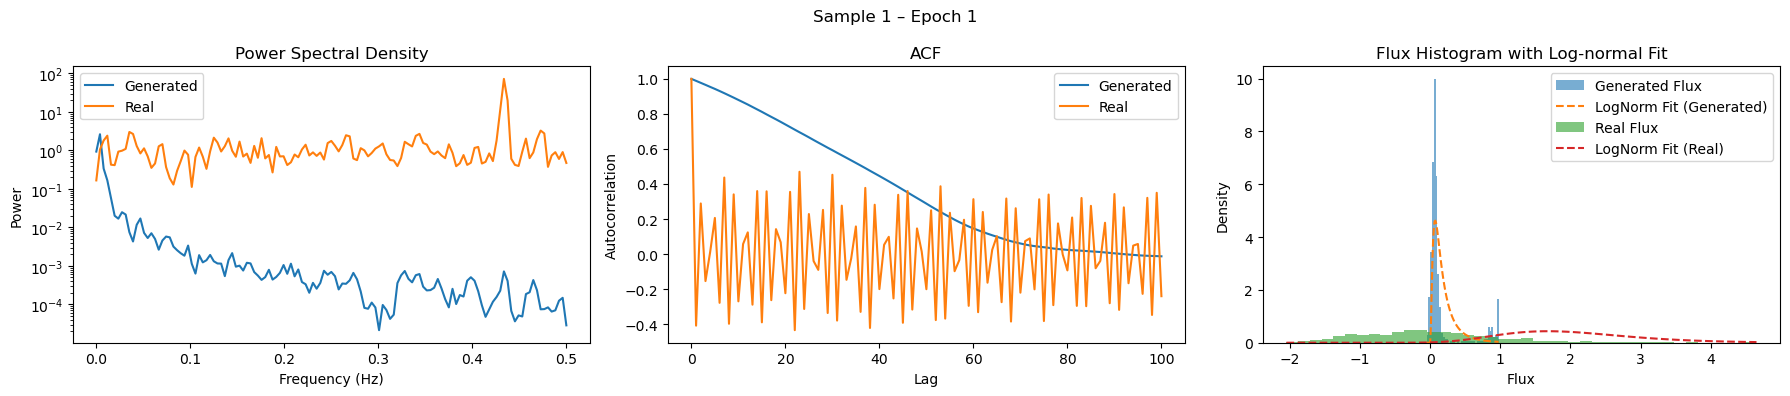

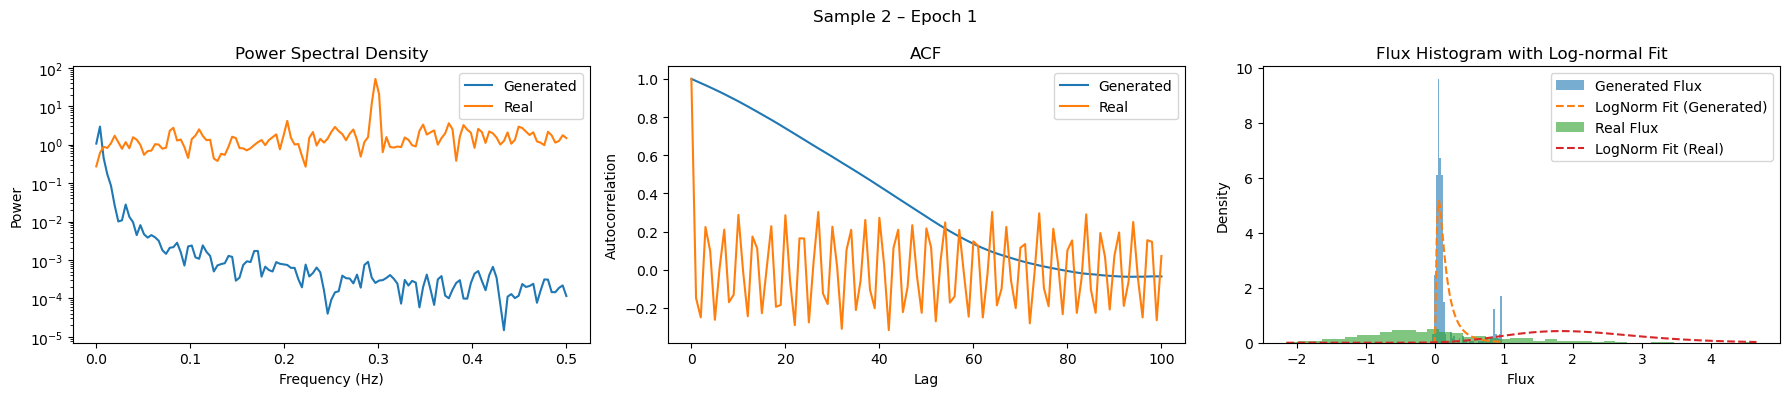

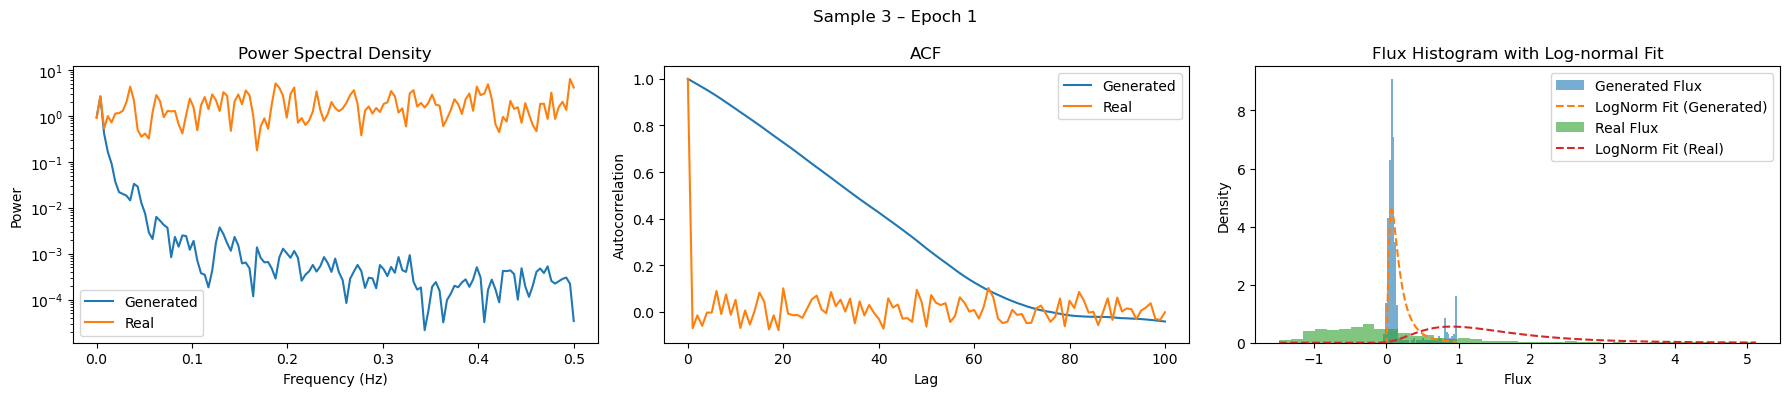

125/125 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - disc_loss: 1.3956 - gen_loss: 0.6680
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - disc_loss: 1.3534 - gen_loss: 0.6832
🧪 Epoch 2: Generating and evaluating samples...


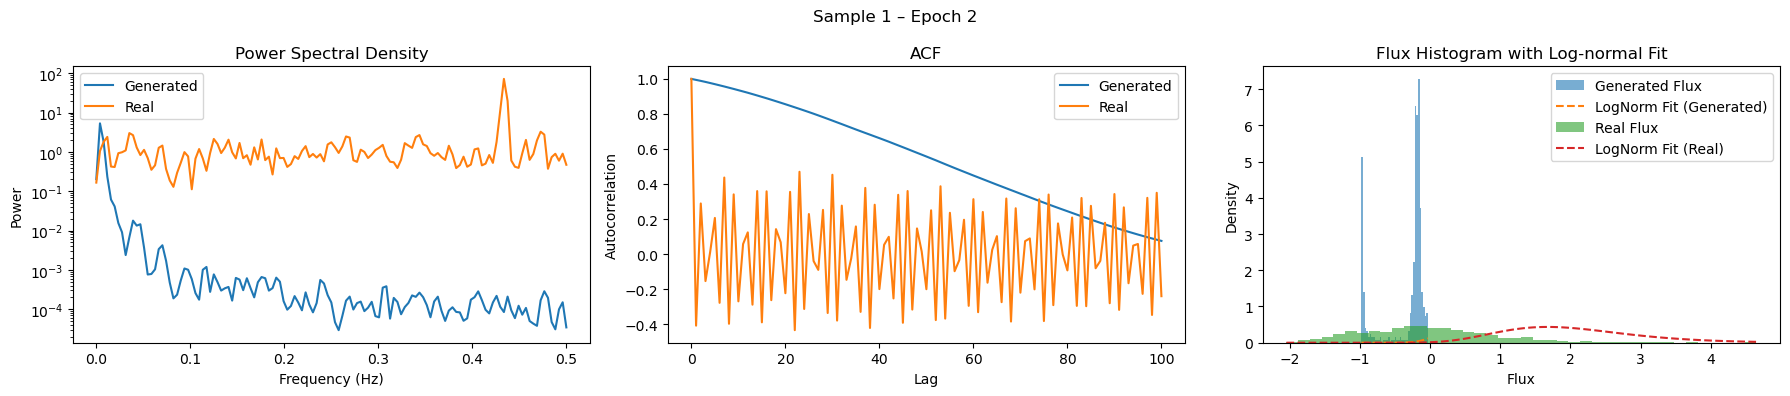

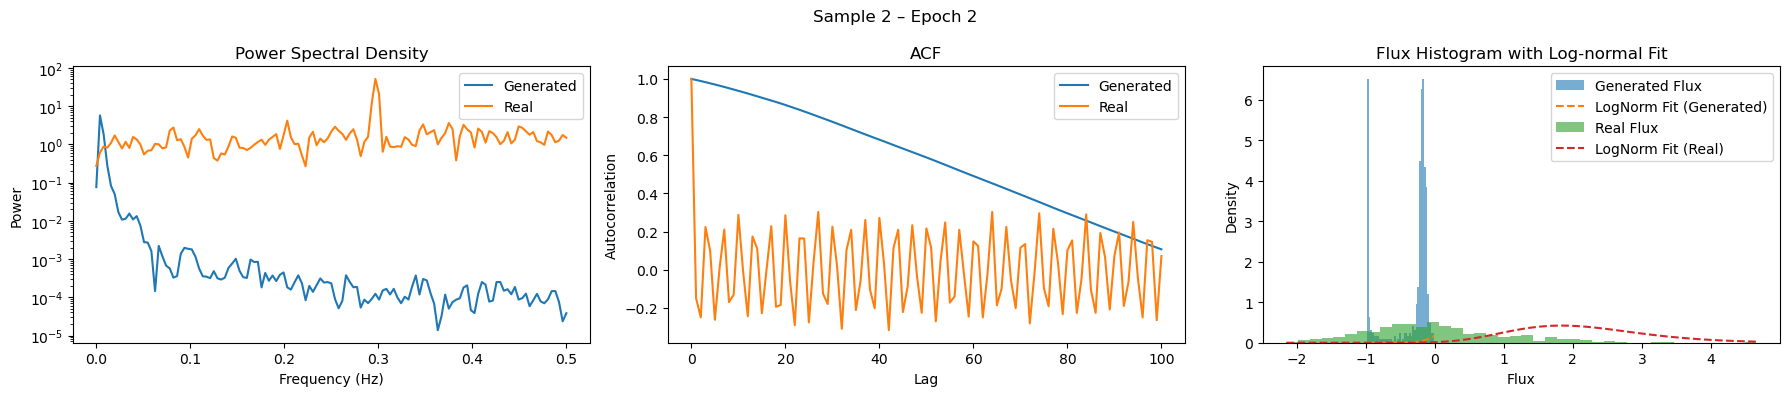

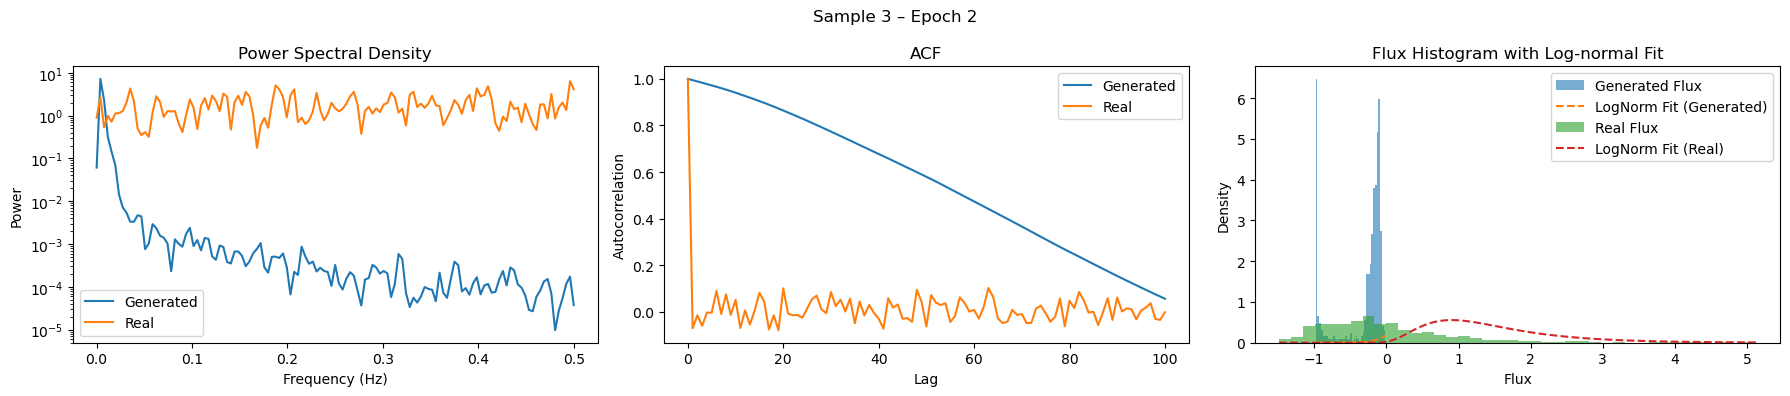

125/125 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - disc_loss: 1.3522 - gen_loss: 0.6843
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - disc_loss: 1.3008 - gen_loss: 0.7469
🧪 Epoch 3: Generating and evaluating samples...


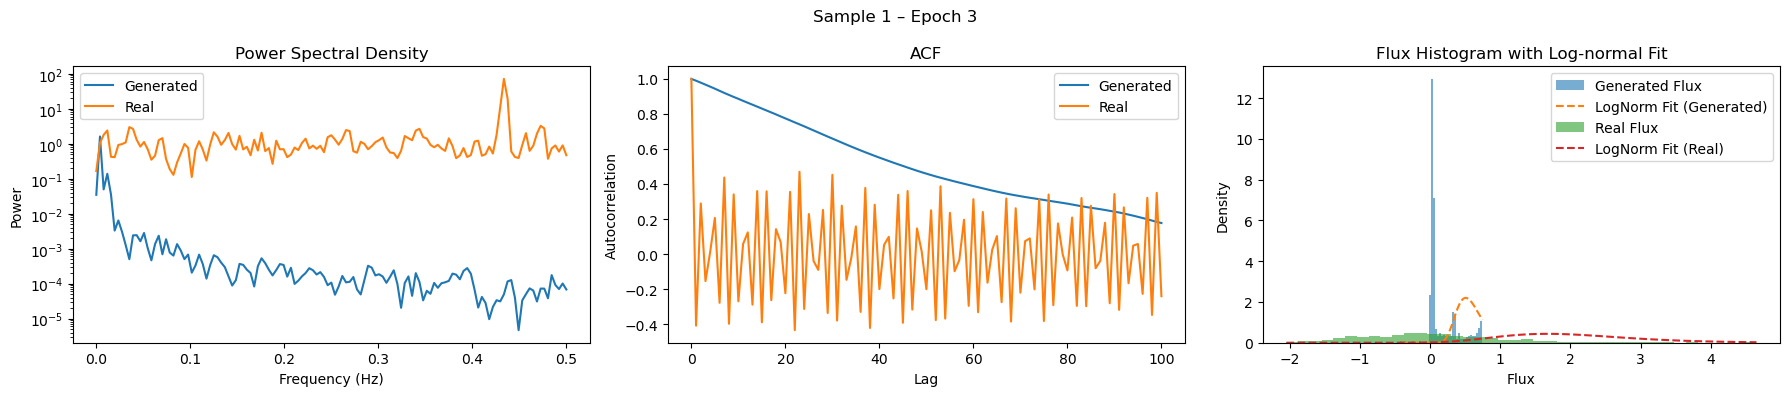

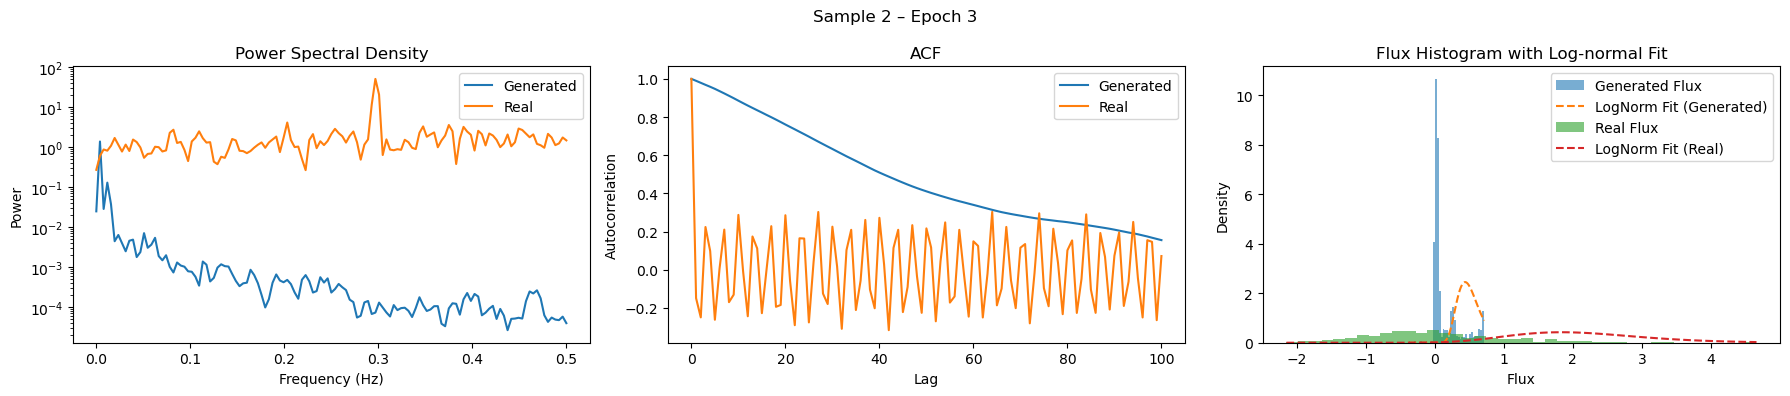

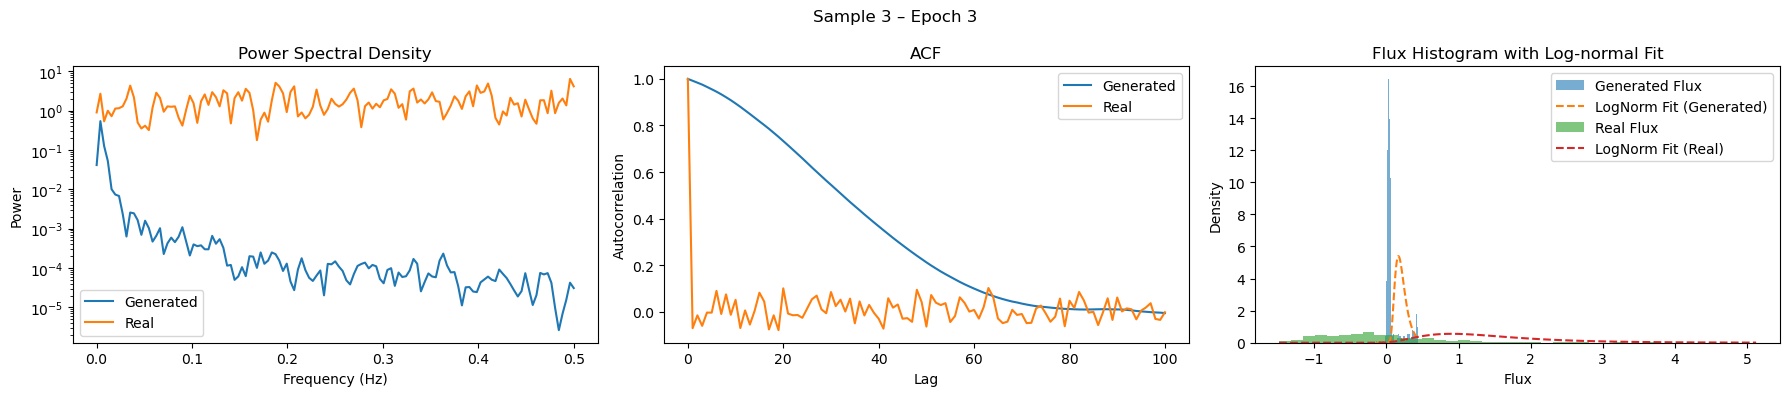

125/125 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - disc_loss: 1.3013 - gen_loss: 0.7462
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - disc_loss: 1.3666 - gen_loss: 0.6818
🧪 Epoch 4: Generating and evaluating samples...


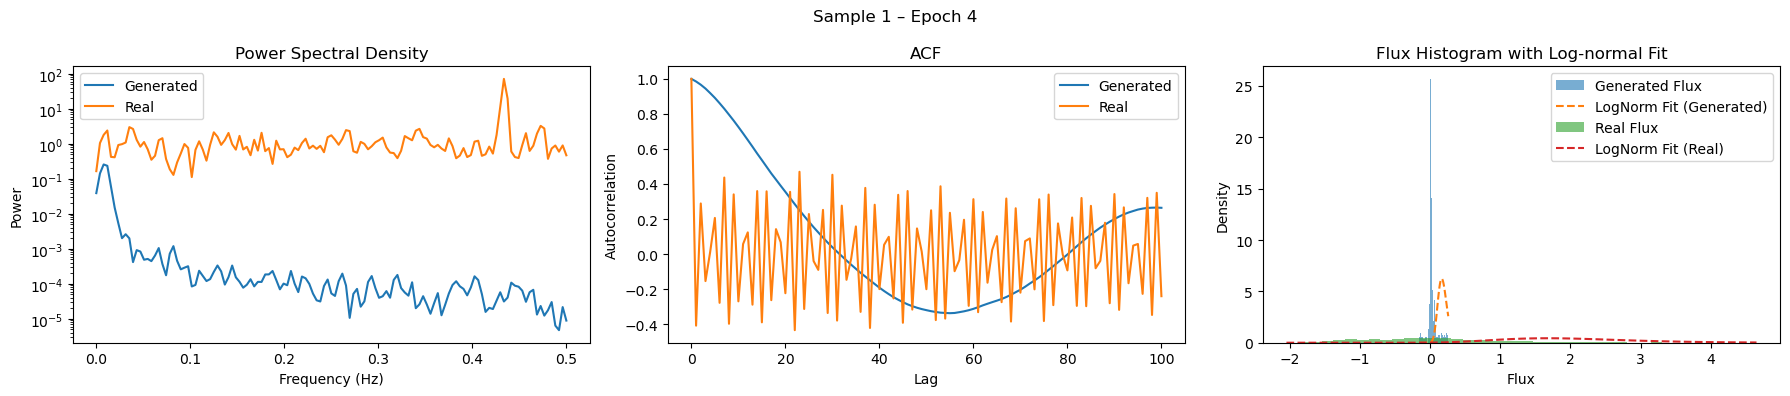

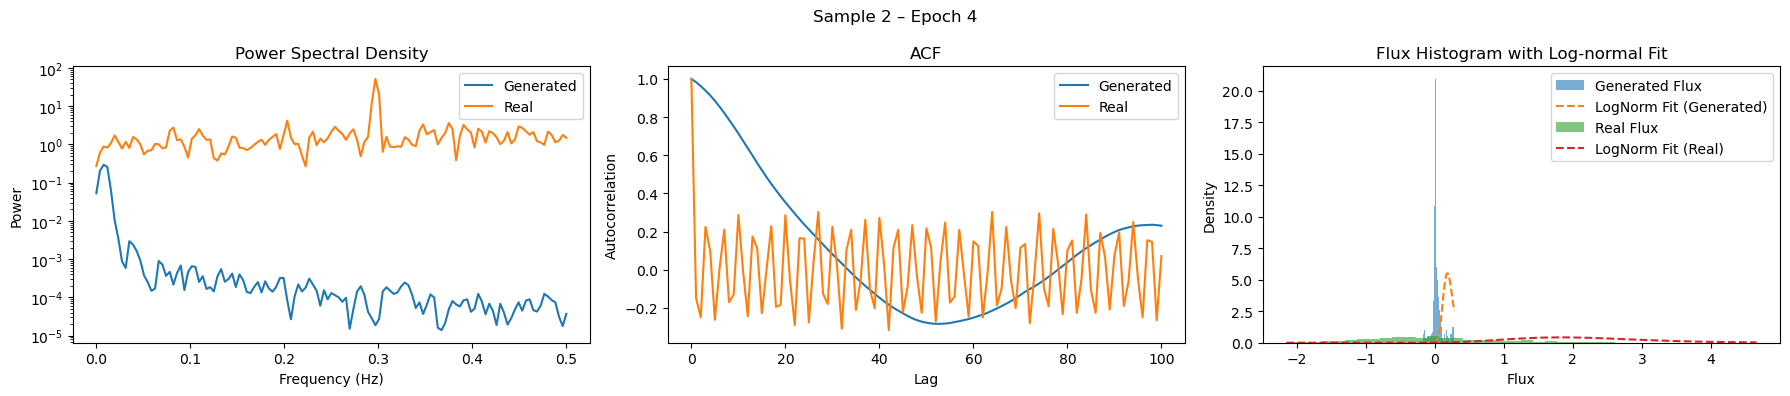

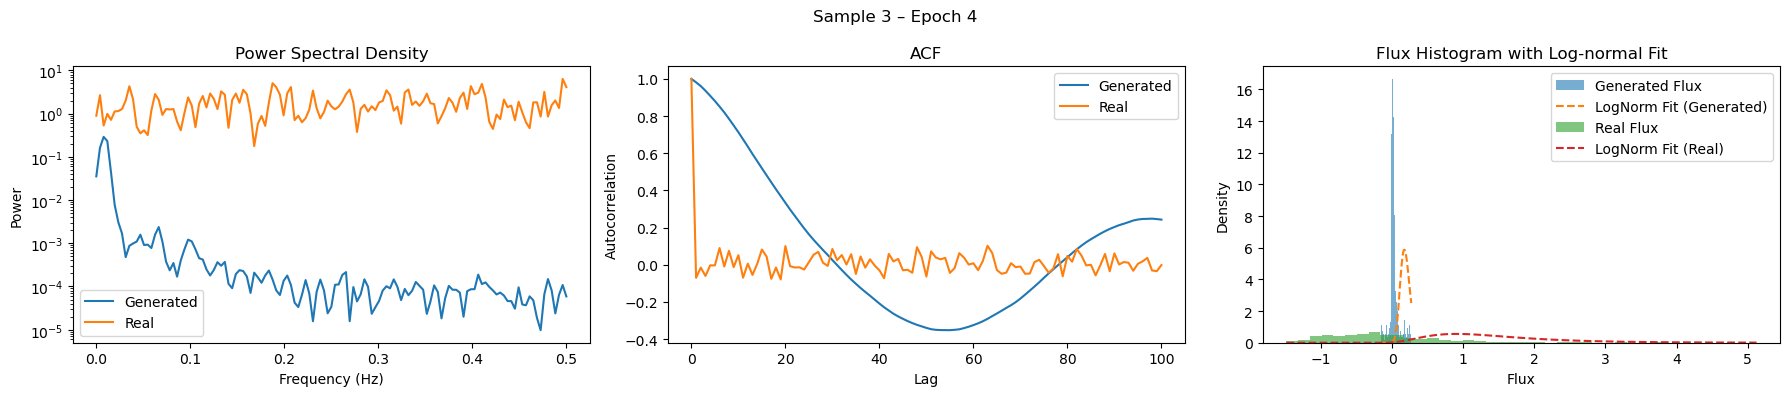

125/125 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - disc_loss: 1.3671 - gen_loss: 0.6813
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - disc_loss: 1.3877 - gen_loss: 0.6738
🧪 Epoch 5: Generating and evaluating samples...


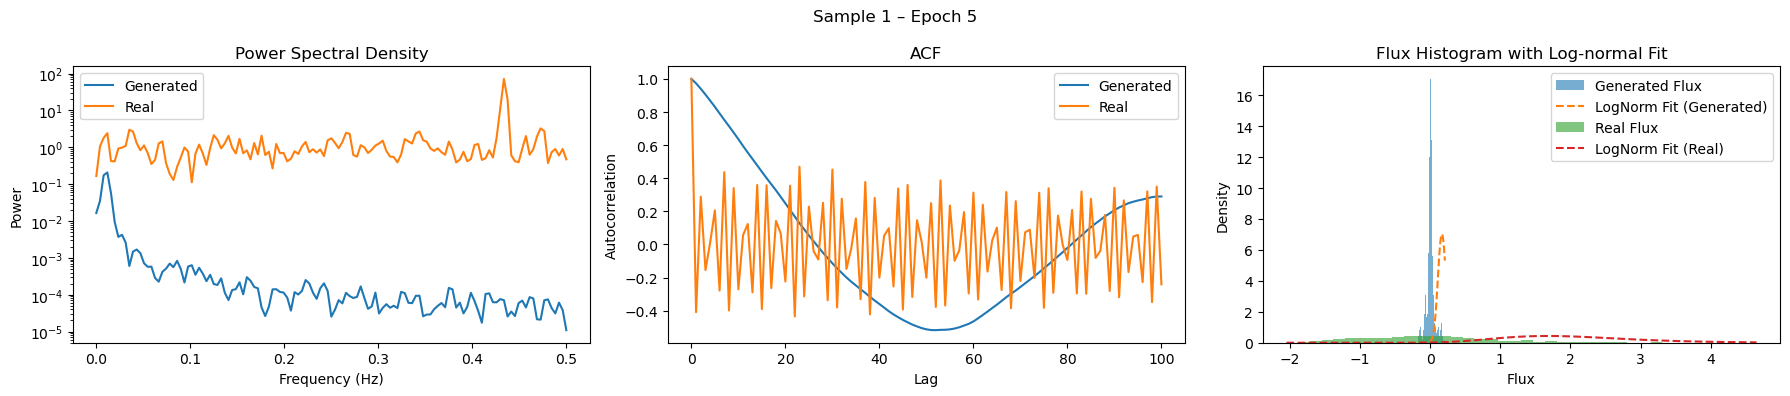

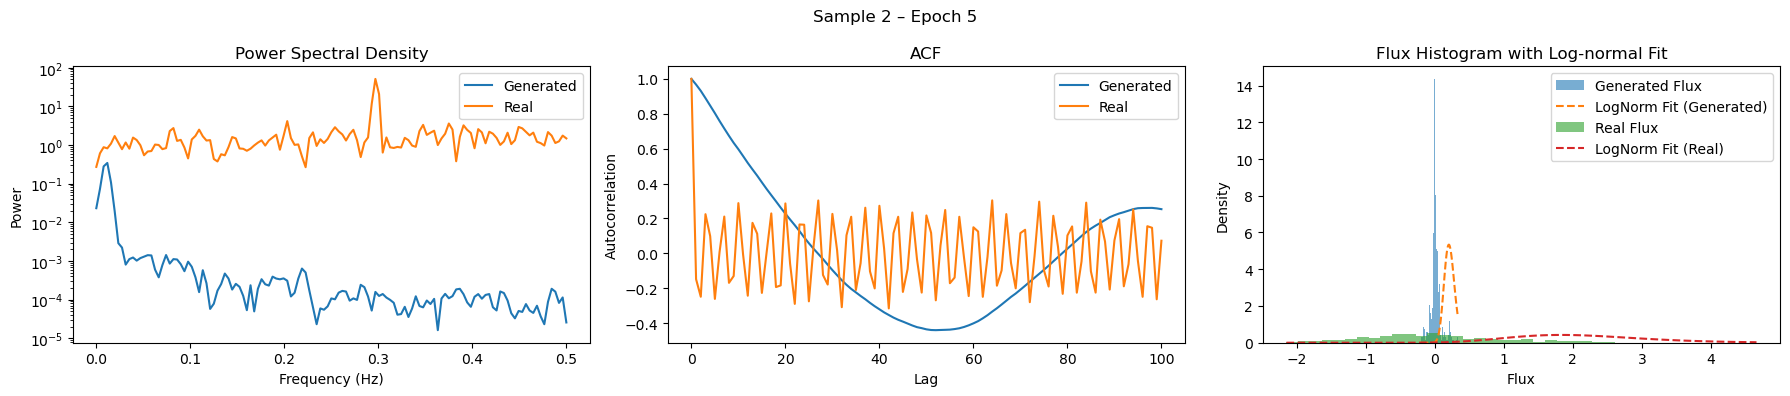

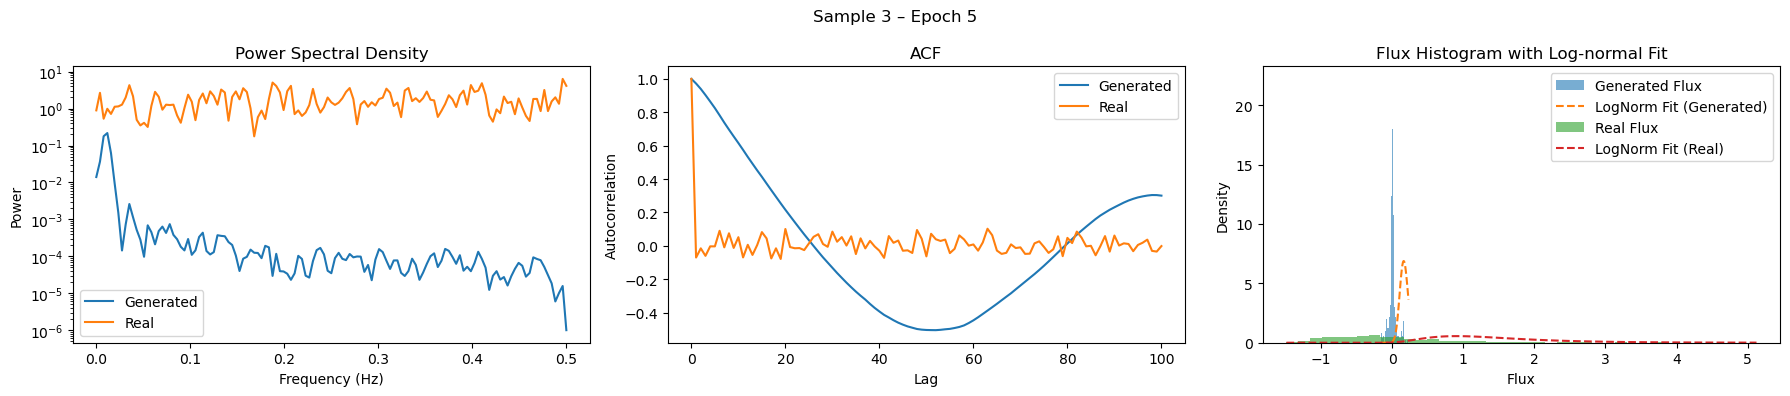

125/125 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - disc_loss: 1.3873 - gen_loss: 0.6741
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - disc_loss: 1.3399 - gen_loss: 0.7096
🧪 Epoch 6: Generating and evaluating samples...


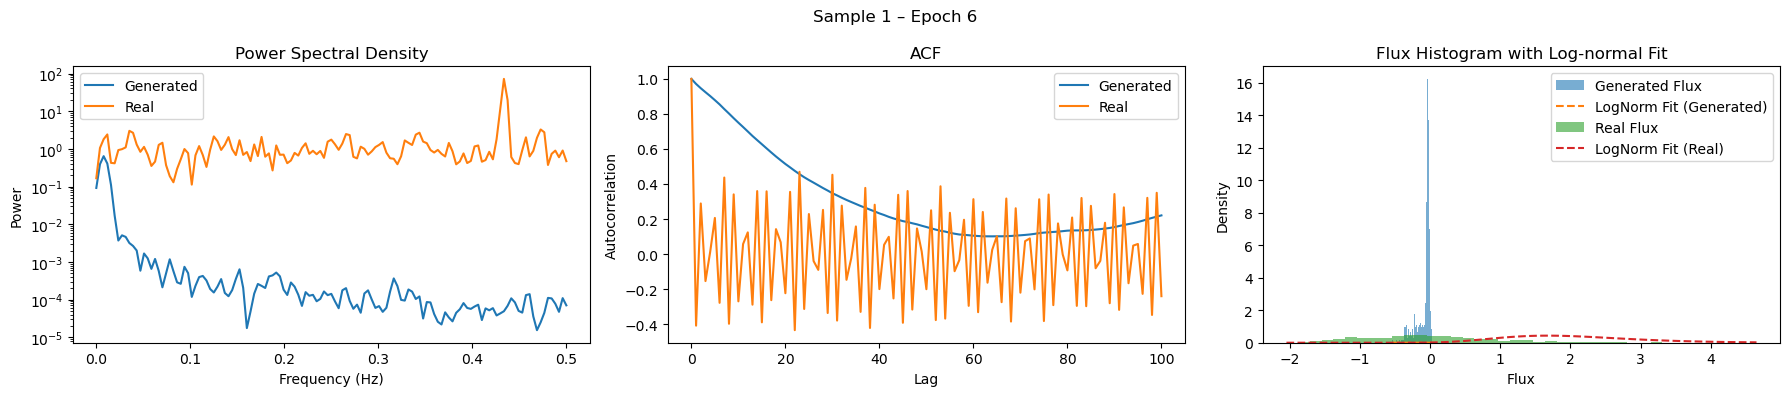

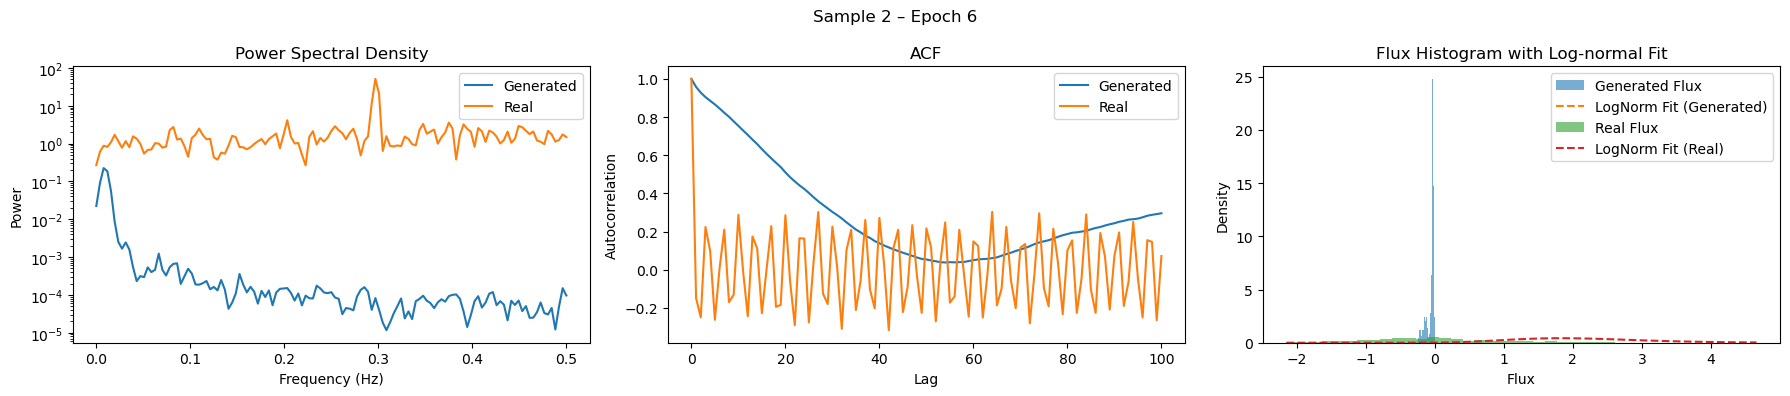

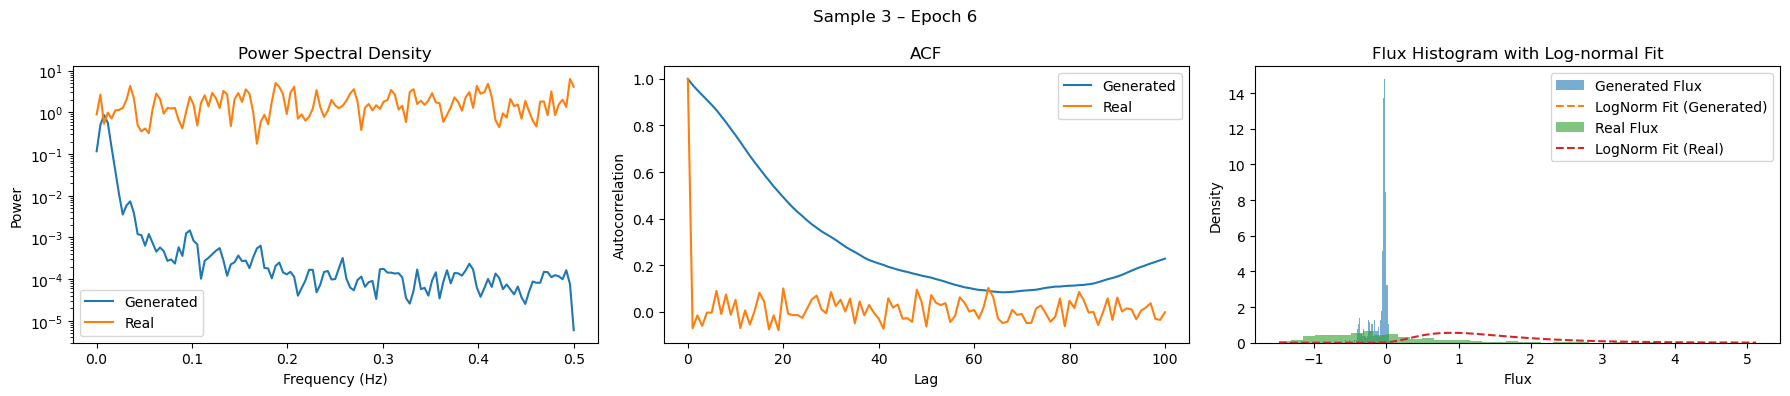

125/125 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - disc_loss: 1.3398 - gen_loss: 0.7101
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - disc_loss: 0.7124 - gen_loss: 2.2001
🧪 Epoch 7: Generating and evaluating samples...


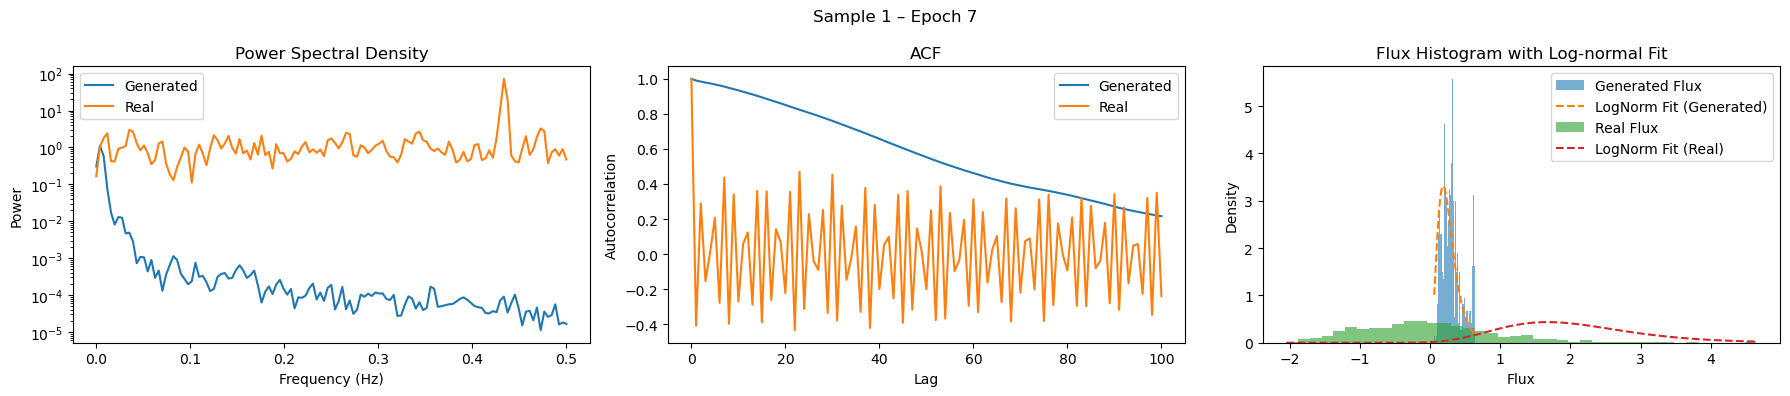

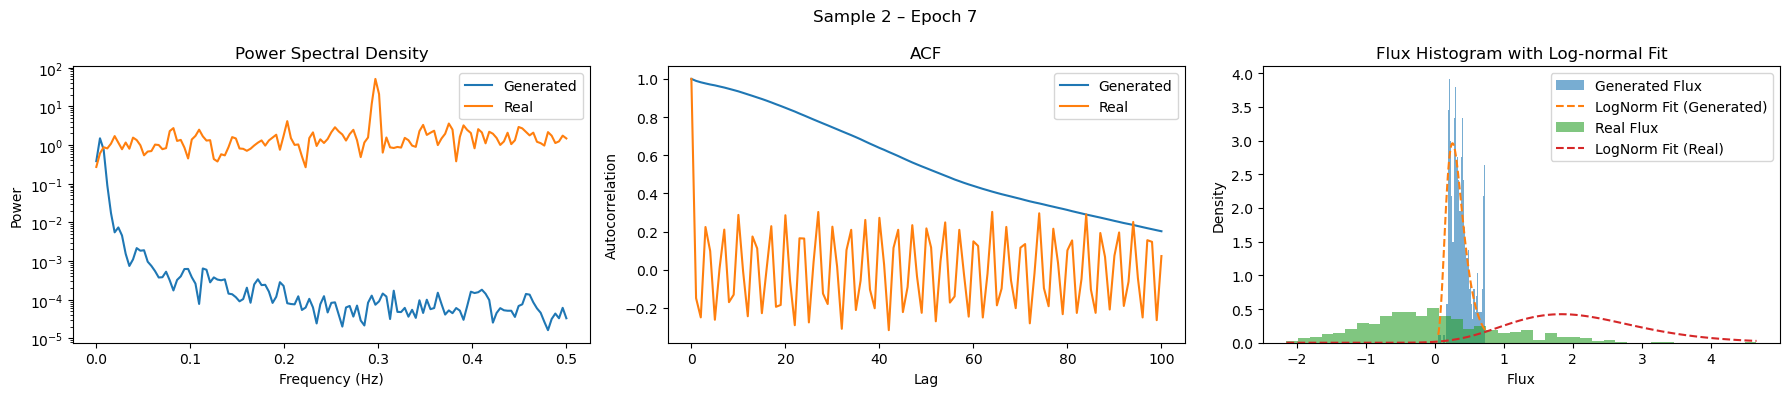

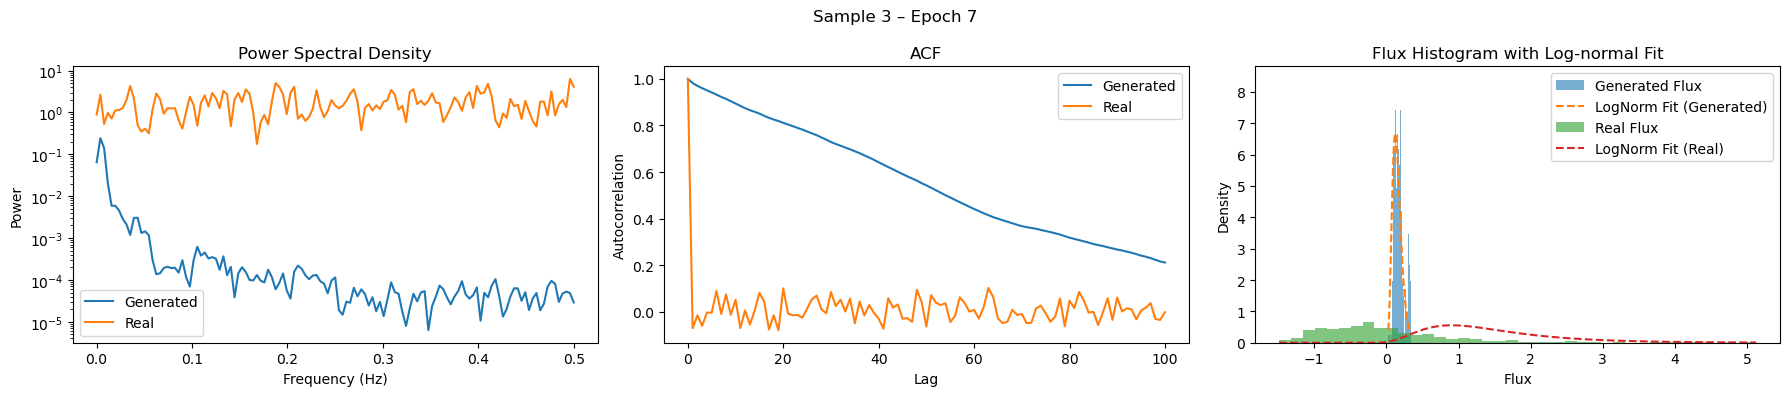

125/125 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - disc_loss: 0.7079 - gen_loss: 2.2150
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - disc_loss: 0.1621 - gen_loss: 4.5418
🧪 Epoch 8: Generating and evaluating samples...


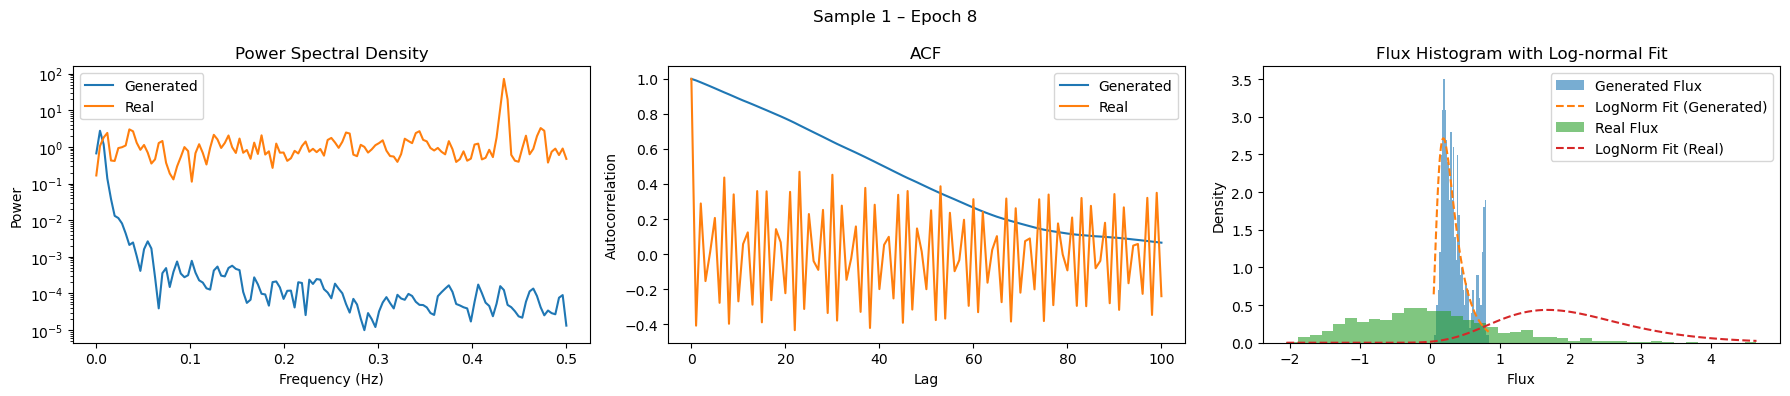

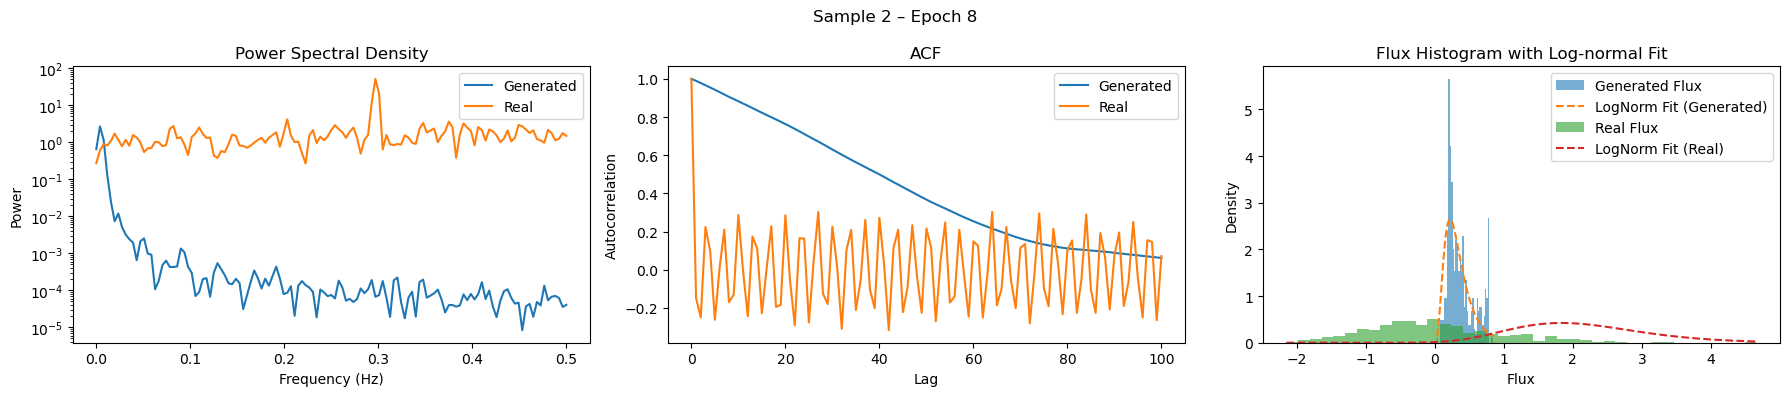

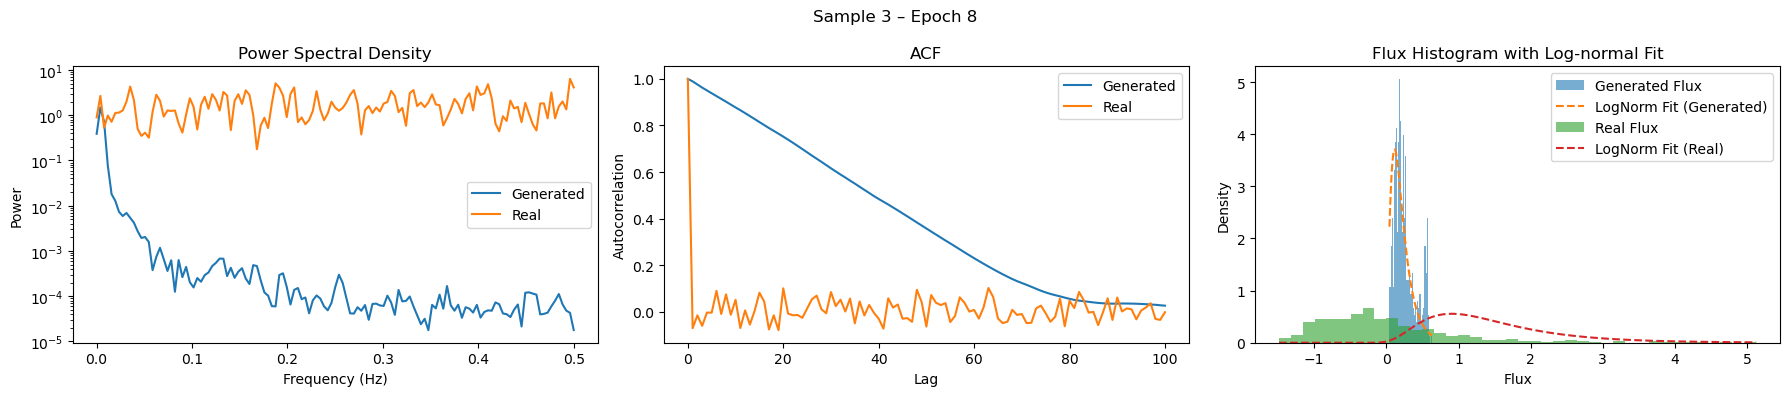

125/125 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - disc_loss: 0.1616 - gen_loss: 4.5447
Epoch 9/50
 16/125 ━━━━━━━━━━━━━━━━━━━━ 6:06 3s/step - disc_loss: 0.1244 - gen_loss: 4.9730

In [ ]:
# Load data
train_ds, val_ds = load_split_dataset(
    "qpo_experiments/dataset_random_amp/data.npz", batch_size=64)

# Build models
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()

# GAN
gan = TimeSeriesGAN(generator, discriminator, latent_dim)
gan.compile()

# Start training
monitor = GANMonitor(generator, val_ds, latent_dim, num_samples=3)
gan.fit(train_ds, epochs=50, callbacks=[monitor])